In [246]:
from itertools import combinations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import OneHotEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score, balanced_accuracy_score

import xgboost as xgb


#custom parameters for the graphs
custom_params = {"axes.spines.right": False, "axes.spines.top": False,
                'axes.facecolor':'whitesmoke'}
sns.set_theme( rc=custom_params)

# Methods

## JMI

In [126]:
class JMI_selector:
    """
    Class for JMI algorithm implementation (the general version)

    Parameters
    ----------
    k: int, optional, default: None
        Number of features to be selected. If not specified, the algorithm 
        select the optimal number.
    
    beta: float, optional, default: None
        Coefficient indicating the strength of the mutual information
        between each selected features and the one not selected. If not specified,
        the inverse of the current number of selected variables will be selected.
        
    gamma: float, optional, default: None    
        Coefficient indicating the impact of conditional mutual information 
        between each selected features and the unselected one, given the 
        class label. If not specified, the inverse of the current number of selected 
        variables will be selected.
    
    """

    def __init__(self, k=None, beta=None, gamma=None, threshold=None):
        self.k = k
        self.beta = beta
        self.gamma = gamma
        self.selected_variables = []
        self.jmi_scores = dict()
        self.info_scores = dict()
        self.threshold = threshold
    
    def __calculate_iteration(self, X, y, var_index:int):
        """
        """
        if self.standard_jmi:
            self.beta = 1/len(self.selected_variables)
            self.gamma = self.beta

        mi_target = mutual_info_score(X[:,var_index].flatten(), y.flatten())
        mi = np.sum(np.array([mutual_info_score(X[:,i].flatten(), X[:,var_index].flatten()) 
                                for i in self.selected_variables]))
        cmi = []
        for sel_var in self.selected_variables:
            cmi.append(np.sum([np.mean(y==y_curr) * mutual_info_score(X[np.where(y==y_curr), sel_var].flatten(), 
                                                                    X[np.where(y==y_curr),var_index].flatten()) 
                                for y_curr in np.unique(y)]))
        cmi_sum = np.sum(cmi)

        return mi_target + self.beta * mi + self.gamma * cmi_sum, np.mean(cmi) - mi/len(self.selected_variables)


    def __calculate_initial(self, X, y):
        """
        """
        mi_target = []
        for var_index in range(X.shape[1]):
            mi_target.append(mutual_info_score(X[:,var_index].flatten(), y.flatten()))

        return np.argmax(mi_target)


    def fit(self, X, y, selected_vars:list=[]):
        """
        n_features = X.shape[1]
        selected_features = []
        mutual_info = np.zeros(n_features)
        """ 

        if type(X) == pd.DataFrame:
            X_copy = X.copy().values
            y_copy = y.values
        elif type(X) == np.ndarray:
            X_copy = X.copy()
            y_copy = y.copy()
        else:
            raise Exception('Incorrect type of the input dataset (has to be pandas.DataFrame or numpy.ndarray)')

        if (self.beta == None) | (self.gamma == None):
            self.standard_jmi = True
        else:
            self.standard_jmi = False

        #if we start from scratch or not
        if len(selected_vars) == 0:
            self.selected_variables.append(self.__calculate_initial(X_copy, y_copy))
        else:
            self.selected_variables = selected_vars

        #if we have not specified number of variables to select
        if self.k == None:
            k = X_copy.shape[1]
        
        for _ in tqdm(range(1,k)):
            
            max_jmi = -np.inf
            best_feature = None
        
            for var_index in range(X_copy.shape[1]):
                if var_index in self.selected_variables:
                    continue
                
                jmi_score, info_score = self.__calculate_iteration(X_copy, y_copy, var_index=var_index)
                
                if jmi_score > max_jmi:
                    max_jmi = jmi_score
                    best_feature = var_index
                    max_info_score = info_score
        
            if self.threshold != None: 
                if max_info_score <= self.threshold:
                    break
            
            self.selected_variables.append(best_feature)
            self.jmi_scores[best_feature] = max_jmi
            self.info_scores[best_feature] = max_info_score
        



## CMIM

In [127]:
class CMIM_selector:
    """
    """
    def __init__(self, k:int=None, threshold:float=None):
        self.k = k
        self.selected_variables = []
        self.cmim_scores = dict()
        self.info_scores = dict()
        self.threshold = threshold


    def __calculate_iteration(self, X, y, var_index:int):
        """
        """

        mi_target = mutual_info_score(X[:,var_index].flatten(), y.flatten())
        mi = np.array([mutual_info_score(X[:,i].flatten(), X[:,var_index].flatten()) 
                        for i in self.selected_variables])
        cmi = []
        for sel_var in self.selected_variables:
            cmi.append(np.sum([np.mean(y==y_curr) * mutual_info_score(X[np.where(y==y_curr),sel_var].flatten(), 
                                                                    X[np.where(y==y_curr),var_index].flatten()) 
                                for y_curr in np.unique(y)]))
        cmi = np.array(cmi)

        return mi_target - np.max(mi - cmi), np.mean(cmi) - np.mean(mi)


    def __calculate_initial(self, X, y):
        """
        """
        mi_target = []
        for var_index in range(X.shape[1]):
            mi_target.append(mutual_info_score(X[:,var_index].flatten(), y.flatten()))

        return np.argmax(mi_target)


    def fit(self, X, y, selected_vars:list=[]):
        """
        n_features = X.shape[1]
        selected_features = []
        mutual_info = np.zeros(n_features)
        """ 
        if type(X) == pd.DataFrame:
            X_copy = X.copy().values
            y_copy = y.values
        elif type(X) == np.ndarray:
            X_copy = X.copy()
            y_copy = y.copy()
        else:
            raise Exception('Incorrect type of the input dataset (has to be pandas.DataFrame or numpy.ndarray)')

        #if we start from scratch or not
        if len(selected_vars) == 0:
            self.selected_variables.append(self.__calculate_initial(X_copy, y_copy))
        else:
            self.selected_variables = selected_vars

        #if we have not specified number of variables to select
        if self.k == None:
            k = X_copy.shape[1]
        
        for _ in tqdm(range(1,k)):
            
            max_cmim = -np.inf
            best_feature = None
        
            for var_index in range(X_copy.shape[1]):
                if var_index in self.selected_variables:
                    continue
                
                cmim_score, info_score = self.__calculate_iteration(X_copy, y_copy, var_index=var_index)
                
                if cmim_score > max_cmim:
                    max_cmim = cmim_score
                    best_feature = var_index
                    max_info_score = info_score
        
            if self.threshold != None: 
                if max_info_score <= self.threshold:
                    break
        
            self.selected_variables.append(best_feature)
            self.cmim_scores[best_feature] = max_cmim
            self.info_scores[best_feature] = max_info_score
        

## Random Forest - feature importance

In [268]:
def custom_combiner(feature, category):
    return str(feature) + "__" + str(category)


def data_preprocessing(X, training_data:bool=True, ohe=None, interval_cols=[]):
    
    X_copy = X.copy()

    cols_to_encode = []
    orig_cols = []
    for col in X_copy.columns:
        if X_copy[col].dtype not in ['int64', 'int32', 'float64', 'float64']:
            if col in interval_cols:
                X_copy[col] = X_copy[col].astype(int)
                orig_cols.append(col)
            else:
                cols_to_encode.append(col)
        else:
            # X_copy[col] = X_copy[col].astype(np.int64)
            orig_cols.append(col)

    #coding categorical variables
    if training_data:
        ohe = OneHotEncoder(drop='first', feature_name_combiner=custom_combiner,
                            sparse_output=False).fit(X_copy[cols_to_encode])
    encoded_cols = ohe.get_feature_names_out().tolist()
    X_copy[encoded_cols] = ohe.transform(X_copy[cols_to_encode])

    return X_copy, cols_to_encode, orig_cols, encoded_cols, ohe


def rf_search_features(X, y, interval_cols:list, discretized:bool=True,
                        training_data=True, ohe=None):
    """
    """
    # X_copy = X.copy()

    # cols_to_encode = []
    # orig_cols = []
    # for col in X_copy.columns:
    #     if X_copy[col].dtype not in ['int64', 'int32', 'float64', 'float64']:
    #         if col in interval_cols:
    #             X_copy[col] = X_copy[col].astype(int)
    #             orig_cols.append(col)
    #         else:
    #             cols_to_encode.append(col)
    #     else:
    #         # X_copy[col] = X_copy[col].astype(np.int64)
    #         orig_cols.append(col)

    # #coding categorical variables
    # ohe = OneHotEncoder(drop='first', feature_name_combiner=custom_combiner,
    #                     sparse_output=False).fit(X_copy[cols_to_encode])
    # encoded_cols = ohe.get_feature_names_out().tolist()
    # X_copy[encoded_cols] = ohe.transform(X_copy[cols_to_encode])

    X_copy, cols_to_encode, orig_cols, encoded_cols, ohe = data_preprocessing(X, training_data=training_data, 
                                                                        ohe=ohe, interval_cols=interval_cols)

    rf_model = RandomForestClassifier(criterion='entropy', max_depth=4, random_state=42, n_estimators=50)

    # print(X_copy[orig_cols+encoded_cols].info())
    boruta_rf = BorutaPy(
                        estimator = rf_model, 
                        n_estimators = 'auto',
                        max_iter = 100 # number of trials to perform
                    )

    np.int = np.int32
    np.float = np.float64
    np.bool = np.bool_
    boruta_rf.fit(X_copy[orig_cols+encoded_cols].values, y.values.ravel())
    rf_model.fit(X_copy[orig_cols+encoded_cols], y)

    jmi = JMI_selector(threshold=0.01)
    jmi.fit(X_copy[orig_cols+encoded_cols], y)

    cmim = CMIM_selector(threshold=0.01)
    cmim.fit(X_copy[orig_cols+encoded_cols], y)

    return rf_model, boruta_rf, jmi, cmim, X_copy[orig_cols+encoded_cols], ohe

# Real datasets

## Statlog (German Credit Data)

Link: https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data

In [25]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144) 
  
# data (as pandas dataframes) 
X1 = statlog_german_credit_data.data.features 
y1 = statlog_german_credit_data.data.targets 
  
# metadata 
print(statlog_german_credit_data.metadata) 
  
# variable information 
print(statlog_german_credit_data.variables) 


{'uci_id': 144, 'name': 'Statlog (German Credit Data)', 'repository_url': 'https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data', 'data_url': 'https://archive.ics.uci.edu/static/public/144/data.csv', 'abstract': 'This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1000, 'num_features': 20, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Other', 'Marital Status', 'Age', 'Occupation'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5NC77', 'creators': ['Hans Hofmann'], 'intro_paper': None, 'additional_info': {'summary': 'Two datasets are provided.  the original dataset, in the form provided by

In [26]:
X1.head()

Attribute1  Attribute2 Attribute3 Attribute4  Attribute5 Attribute6  \
0        A11           6        A34        A43        1169        A65   
1        A12          48        A32        A43        5951        A61   
2        A14          12        A34        A46        2096        A61   
3        A11          42        A32        A42        7882        A61   
4        A11          24        A33        A40        4870        A61   

  Attribute7  Attribute8 Attribute9 Attribute10  Attribute11 Attribute12  \
0        A75           4        A93        A101            4        A121   
1        A73           2        A92        A101            2        A121   
2        A74           2        A93        A101            3        A121   
3        A74           2        A93        A103            4        A122   
4        A73           3        A93        A101            4        A124   

   Attribute13 Attribute14 Attribute15  Attribute16 Attribute17  Attribute18  \
0           67        A143        A152            2        A173            1   
1           22        A143        A152            1        A173            1   
2           49        A143        A152            1        A172            2   
3           45        A143        A153            1        A173            2   
4           53        A143        A153            2        A173            2   

  Attribute19 Attribute20  
0        A192        A201  
1        A191        A201  
2        A191        A201  
3        A191        A201  
4        A191        A201

In [27]:
X1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Attribute1   1000 non-null   object
 1   Attribute2   1000 non-null   int64 
 2   Attribute3   1000 non-null   object
 3   Attribute4   1000 non-null   object
 4   Attribute5   1000 non-null   int64 
 5   Attribute6   1000 non-null   object
 6   Attribute7   1000 non-null   object
 7   Attribute8   1000 non-null   int64 
 8   Attribute9   1000 non-null   object
 9   Attribute10  1000 non-null   object
 10  Attribute11  1000 non-null   int64 
 11  Attribute12  1000 non-null   object
 12  Attribute13  1000 non-null   int64 
 13  Attribute14  1000 non-null   object
 14  Attribute15  1000 non-null   object
 15  Attribute16  1000 non-null   int64 
 16  Attribute17  1000 non-null   object
 17  Attribute18  1000 non-null   int64 
 18  Attribute19  1000 non-null   object
 19  Attribute20  1000 non-null  

In [28]:
#number of categories
{col:np.unique(X1[col].values) for col in X1.columns if X1[col].dtype=='object'}

{'Attribute1': array(['A11', 'A12', 'A13', 'A14'], dtype=object),
 'Attribute3': array(['A30', 'A31', 'A32', 'A33', 'A34'], dtype=object),
 'Attribute4': array(['A40', 'A41', 'A410', 'A42', 'A43', 'A44', 'A45', 'A46', 'A48',
        'A49'], dtype=object),
 'Attribute6': array(['A61', 'A62', 'A63', 'A64', 'A65'], dtype=object),
 'Attribute7': array(['A71', 'A72', 'A73', 'A74', 'A75'], dtype=object),
 'Attribute9': array(['A91', 'A92', 'A93', 'A94'], dtype=object),
 'Attribute10': array(['A101', 'A102', 'A103'], dtype=object),
 'Attribute12': array(['A121', 'A122', 'A123', 'A124'], dtype=object),
 'Attribute14': array(['A141', 'A142', 'A143'], dtype=object),
 'Attribute15': array(['A151', 'A152', 'A153'], dtype=object),
 'Attribute17': array(['A171', 'A172', 'A173', 'A174'], dtype=object),
 'Attribute19': array(['A191', 'A192'], dtype=object),
 'Attribute20': array(['A201', 'A202'], dtype=object)}

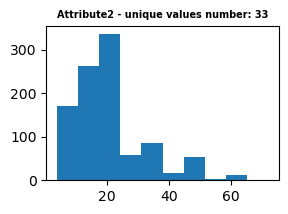

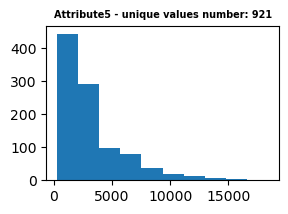

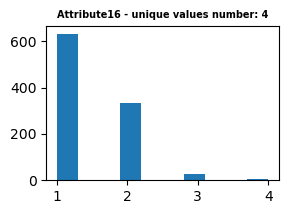

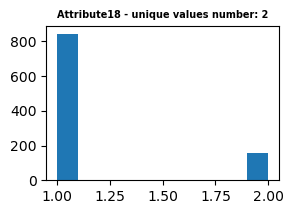

In [31]:
for col in X1.columns:
    if X1[col].dtype=='int64':
        plt.figure(figsize=(3,2))
        plt.hist(X1[col])
        plt.title(str(col) + f' - unique values number: {np.unique(X1[col]).shape[0]}', 
                    fontweight='bold', fontsize=7)
        plt.show()

Conclusion: Only variables "Attribute2", "Attribute5" and "Attribute13" can be treated as interval. We will discretize them.

In [103]:
X1_disc = X1.copy()
for interv_cols in ["Attribute2","Attribute5","Attribute13"]:
    X1_disc[interv_cols] = pd.qcut(X1_disc[interv_cols], q=6, duplicates='drop', labels=np.arange(1,7))

X1_train, X1_test, y1_train, y1_test = train_test_split(X1_disc, y1, test_size=0.3)

In [234]:
jmi_1_orig = JMI_selector(threshold=0.01)
jmi_1.fit(X1_train, y1_train)

cmim_1 = CMIM_selector(threshold=0.01)
cmim_1.fit(X1_train, y1_train)

 79%|███████▉  | 15/19 [00:10<00:02,  1.49it/s]


In [280]:
X1_test_processed, cols_to_encode, orig_cols, encoded_cols, ohe = data_preprocessing(X1_test, training_data=False, 
                                                                            ohe=ohe, interval_cols=["Attribute2","Attribute5","Attribute13"])

In [269]:
rf_model, boruta_rf, jmi_1_enc, cmim_1_enc, X1_train_processed, ohe = rf_search_features(X1_train, y1_train, interval_cols=["Attribute2","Attribute5","Attribute13"])

c:\Users\patry\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
 45%|████▍     | 21/47 [00:36<00:44,  1.72s/it]


In [281]:
X1_train_processed.shape, X1_test_processed.shape

((700, 48), (300, 61))

In [273]:
boruta_rf.n_features_, boruta_rf.support_, boruta_rf.ranking_

(5,
 array([ True,  True, False, False,  True, False, False, False, False,
         True, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([ 1,  1,  2, 14,  1, 13, 33,  9, 31,  1,  6, 25, 32,  1,  3, 41, 21,
         4, 43, 39, 40, 42, 29, 38, 17, 18,  2, 17, 26, 10, 20, 30, 23, 38,
        11, 15, 35, 23,  8, 35,  7,  5, 27, 28, 36, 23, 19, 13]))

In [274]:
np.argsort(boruta_rf.ranking_)

array([ 0,  1,  4,  9, 13,  2, 26, 14, 17, 41, 10, 40, 38,  7, 29, 34, 47,
        5,  3, 35, 24, 27, 25, 46, 30, 16, 37, 32, 45, 11, 28, 42, 43, 22,
       31,  8, 12,  6, 39, 36, 44, 23, 33, 19, 20, 15, 21, 18],
      dtype=int64)

In [286]:
def compare_choices(rf_model, boruta_rf, jmi_1_enc, cmim_1_enc, X_train, y_train, X_test, y_test):
    
    method_dict = {'rf':[], 'boruta':[], 'jmi':[], 'cmim':[]}
    y_train_01 = y_train-1
    y_test_01 = y_test-1
    
    xgb_auc_results = {'train':method_dict.copy(), 'test':method_dict.copy()}
    xgb_balanced_acc_results = {'train':method_dict.copy(), 'test':method_dict.copy()}
    logreg_auc_results = {'train':method_dict.copy(), 'test':method_dict.copy()}
    logreg_balanced_acc_results = {'train':method_dict.copy(), 'test':method_dict.copy()}

    rf_model_features = np.argsort(rf_model.feature_importances_)[::-1]
    boruta_rf_features = np.argsort(boruta_rf.ranking_)
    jmi_1_enc_scores = np.array(jmi_1_enc.selected_variables)
    cmim_1_enc_features = np.array(cmim_1_enc.selected_variables)

    features_dict = {'rf':rf_model_features, 'boruta':boruta_rf_features,
                    'jmi':jmi_1_enc_scores, 'cmim':cmim_1_enc}

    for i in tqdm(range(1,X_train.shape[1])):
        for method in features_dict.keys():
            curr_features = features_dict[method][0: min(i,features_dict[method].shape[0])]
            xgb_model = xgb.XGBClassifier(tree_method='hist', verbosity=0, colsample_bytree=0.7,
                                        eta=0.1, max_depth=3, n_estimators=50, random_state=123,
                                        eval_metric=roc_auc_score)
            xgb_model.fit(X_train.values[:,curr_features], y_train_01, verbose=False)

            logreg = LogisticRegression(penalty='l2', C=10, max_iter=1000).fit(X_train.values[:,curr_features], y_train_01)

            xgb_auc_results['train'][method] = roc_auc_score(xgb_model.predict_proba(X_train.values[:,curr_features])[:,1], y_train_01)
            xgb_auc_results['test'][method] = roc_auc_score(xgb_model.predict_proba(X_test.values[:,curr_features])[:,1], y_test_01)
            xgb_balanced_acc_results['train'][method] = balanced_accuracy_score(xgb_model.predict_proba(X_train.values[:,curr_features])[:,1], y_train_01)
            xgb_balanced_acc_results['test'][method] = balanced_accuracy_score(xgb_model.predict_proba(X_test.values[:,curr_features])[:,1], y_test_01)

            logreg_auc_results['train'][method] = roc_auc_score(logreg.predict_proba(X_train.values[:,curr_features])[:,1], y_train_01)
            logreg_auc_results['test'][method] = roc_auc_score(logreg.predict_proba(X_test.values[:,curr_features])[:,1], y_test_01)
            logreg_balanced_acc_results['train'][method] = balanced_accuracy_score(logreg.predict_proba(X_train.values[:,curr_features])[:,1], y_train_01)
            logreg_balanced_acc_results['test'][method] = balanced_accuracy_score(logreg.predict_proba(X_test.values[:,curr_features])[:,1], y_test_01)

    return xgb_auc_results, xgb_auc_results, xgb_balanced_acc_results, xgb_balanced_acc_results

In [287]:
xgb_auc_results1, xgb_auc_results1, xgb_balanced_acc_results1, xgb_balanced_acc_results1 = compare_choices(rf_model, boruta_rf, jmi_1_enc, cmim_1_enc, 
                                                                                                            X1_train_processed, y1_train, X1_test_processed, y1_test)

  0%|          | 0/47 [00:00<?, ?it/s]c:\Users\patry\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
  0%|          | 0/47 [00:00<?, ?it/s]


ValueError: continuous format is not supported